# Coherent dark states in a 3-level system
Investigating coherent dark states in 3-level system using the `toy_systems` package. 

The 3-level system will consist of two ground states which are both coupled to the same excited state, which in turn can decay back to both of the ground states. A similar situation can be found in TlF when driving optical transitions from the electronic ground state X to the excited state B. The spacing of hyperfine levels in X is much smaller than the natural linewidth of the transitions, so that multiple groundstate hyperfine states end up coupling to one excited state hyperfine state. The number of coherent dark states in this scenario is N-1 where N is the number of ground states coupling to the same excited state. The dark states are typically not eigenstates of the internal Hamiltonian (e.g. TlF internal Hamiltonian) and so they evolve into bright states over time - we'll investigate the rate at which this occurs as the coupling strength of the ground states to the excited state and their energy splitting is varied.
## Imports
Start by importing the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import scipy
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.dark_states import get_dark_states
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Set up states and basis
We start by defining the three states of the system: the ground states $|g0\rangle$ and $|g1\rangle$, and the excited state $|e\rangle$>

In [2]:
g0 = BasisState(qn=ToyQuantumNumbers(label="g0"))
g1 = BasisState(qn=ToyQuantumNumbers(label="g1"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Define basis
basis = Basis((g0,g1,e))
basis.print()

|0> = |g0>
|1> = |g1>
|2> = |e>


## Define energies, couplings, decays and quantum system
I'm going to define the system in the rotating frame as usual.

### Energies

In [3]:
δ = Symbol('delta') # Energy splitting between |g0> and |g1
Δ = Symbol('Delta') # Detuning of drive field from 0
E0 = ToyEnergy([g0], -δ/2)
E1 = ToyEnergy([g1], +δ/2)
Ee = ToyEnergy([e], Δ)

### Couplings

In [4]:
Ω0 = Symbol('Omega_0') # Drive field Rabi rate for |g0> <-> |e>
Ω1 = Symbol('Omega_1') # Drive field Rabi rate for |g1> <-> |e>

coupling_0 = ToyCoupling(g0,e,Ω0)
coupling_1 = ToyCoupling(g1,e,Ω1)

### Decays
Defining a decay from $|e\rangle$ to $|g0\rangle$ and $|g1\rangle$:

In [5]:
decay_0 = ToyDecay(e, ground = g0, gamma = Symbol("Gamma_0"))
decay_1 = ToyDecay(e, ground = g1, gamma = Symbol("Gamma_1"))

### Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

In [6]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E0, E1, Ee, coupling_0, coupling_1],
    decays=[decay_0, decay_1],
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Find dark states
There is some rudimentary functionality in `toy_systems` for finding the bright and dark states when a number of ground states are coupled to a single excited state. Let's test that here:

In [10]:
bright_state, dark_states, pol_dark_states = get_dark_states([g0, g1], e, [coupling_0, coupling_1])

print(f"|B> =\n{bright_state[0]}")

print(f"\n|D> =\n{dark_states[0]}")

print(f"\n<B|D> = {dark_states[0]@bright_state[0]}")

|B> =
0.71+0.00j x |g0>
0.71+0.00j x |g1>

|D> =
0.71+0.00j x |g0>
-0.71+0.00j x |g1>

<B|D> = 0j


## Time evolution
No matter what state the system starts in, it should always end up in the dark state, from which it will slowly evolve out since the dark state is not an eigenstate of the Hamiltonian.

In [11]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'delta': 1, 'Delta': 1, 'Omega_0': 1, 'Omega_1': 1, 'Gamma_0': 1, 'Gamma_1': 1}


In [12]:
dark_states

[0.71+0.00j x |g0>
 -0.71+0.00j x |g1>]

In [13]:
bright_state

[0.71+0.00j x |g0>
 0.71+0.00j x |g1>]

In [22]:
# Set the parameters for the system
args['delta'] = 0.05
args['Delta'] = 0
args['Omega_0'] = 1
args['Omega_1'] = 1
args['Gamma_0'] = 1/2
args['Gamma_1'] = 1/2
Gamma = args['Gamma_0'] + args['Gamma_1']

# Get different dark and bright states for different values of Omegas so recalculate them
coupling_0.mag = args["Omega_0"]
coupling_1.mag = args["Omega_1"]
bright_states, dark_states, pol_dark_states = get_dark_states([g0, g1], e, [coupling_0, coupling_1])

# Generate a Qobj representing the initial state
psi0 = (1*dark_states[0]).qobj(basis)

# Operators for getting probability of being in each state as a function of time
P_g0 = qutip.Qobj((1*g0).density_matrix(basis), type = "oper")
P_g1 = qutip.Qobj((1*g1).density_matrix(basis), type = "oper")
P_e = qutip.Qobj((1*e).density_matrix(basis), type = "oper")
P_B = qutip.Qobj(bright_states[0].density_matrix(basis), type = "oper")
P_D = qutip.Qobj(dark_states[0].density_matrix(basis), type = "oper")
P_ops = [P_g0, P_g1, P_e, P_B, P_D]

# Times at which result is requested
times = np.linspace(0,100/args['delta'],1001)

# Setting the max_step is sometimes necessary
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0, rhs_reuse=True)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = P_ops,
                      progress_bar=pb, options = options)

 Total run time:   0.81s*] Elapsed 0.81s / Remaining 00:00:00:00


|B> =
[0.71+0.00j x |g0>
0.71+0.00j x |g1>]

|D> =
0.71+0.00j x |g0>
-0.71+0.00j x |g1>

Population in excited state at the end: 1.3e+01 %
Photons per unit time: 1.34e-01


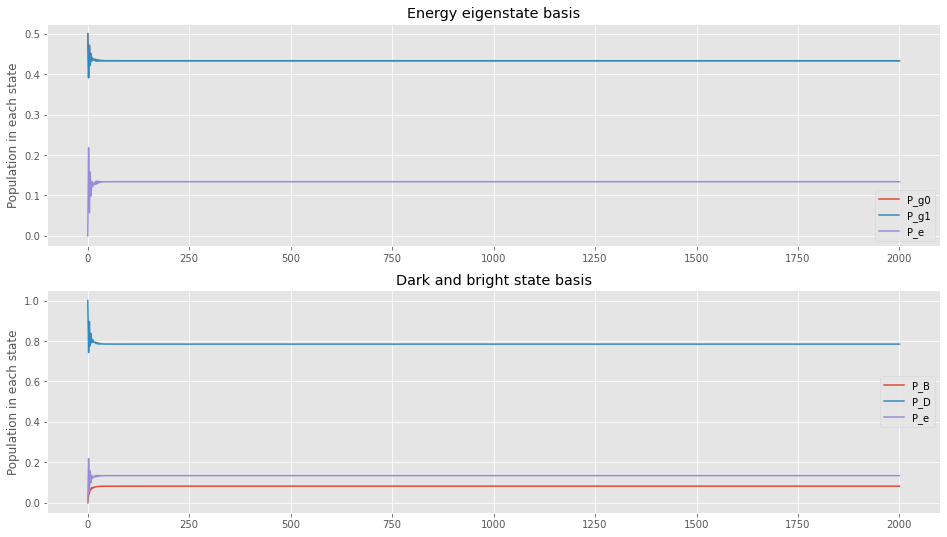

In [23]:
fig, ax = plt.subplots(2, 1, figsize = (16,9))
ax[0].plot(times, result.expect[0], label = "P_g0")
ax[0].plot(times, result.expect[1], label = "P_g1")
ax[0].plot(times, result.expect[2], label = "P_e")
ax[0].legend()
ax[0].set_ylabel("Population in each state")
ax[0].set_title("Energy eigenstate basis")

ax[1].plot(times, result.expect[3], label = "P_B")
ax[1].plot(times, result.expect[4], label = "P_D")
ax[1].plot(times, result.expect[2], label = "P_e")
ax[1].legend()
ax[1].set_ylabel("Population in each state")
ax[1].set_title("Dark and bright state basis")


print(f"|B> =\n{bright_state}")

print(f"\n|D> =\n{dark_states[0]}")

print(f"\nPopulation in excited state at the end: {result.expect[2][-1]*100:.1e} %")
print(f"Photons per unit time: {scipy.integrate.trapezoid(result.expect[2], x = times)/times[-1]:.2e}")

## Parameter scans

In [26]:
default_args = {}
default_args['delta'] = 0.1
default_args['Delta'] = 0
default_args['Omega_0'] = 1
default_args['Omega_1'] = 1
default_args['Gamma_0'] = 1/2
default_args['Gamma_1'] = 1/2

# Define function that will be executed in parallel
def parallel_func(args):
    
    # Calculate total decay rate
    Gamma = args['Gamma_0'] + args['Gamma_1']

    # Get different dark and bright states for different values of Omegas so recalculate them
    coupling_0.mag = args["Omega_0"]
    coupling_1.mag = args["Omega_1"]
    bright_state, dark_states, pol_dark_states = get_dark_states([g0, g1], e, [coupling_0, coupling_1])

    # Generate a Qobj representing the initial state
    psi0 = (1*dark_states[0]).qobj(basis)

    # Operators for getting probability of being in each state as a function of time
    P_g0 = qutip.Qobj((1*g0).density_matrix(basis), type = "oper")
    P_g1 = qutip.Qobj((1*g1).density_matrix(basis), type = "oper")
    P_e = qutip.Qobj((1*e).density_matrix(basis), type = "oper")
    P_B = qutip.Qobj(bright_states[0].density_matrix(basis), type = "oper")
    P_D = qutip.Qobj(dark_states[0].density_matrix(basis), type = "oper")
    P_ops = [P_g0, P_g1, P_e, P_B, P_D]

    # Times at which result is requested
    times = np.linspace(0,100/args['delta'],1001)

    # Setting the max_step is sometimes necessary
    options = qutip.solver.Options(method = 'adams', nsteps=1000000, max_step=1e2/args["delta"], rhs_reuse=True)

    # Run the time-evolution
    result = qutip.mesolve(Hqobj, psi0, times, args = args, c_ops = c_qobj, e_ops = P_ops, options = options)
    
    # Calculate rate at which photons are emitted
    rate = scipy.integrate.trapezoid(result.expect[2], x = times)/times[-1]
    
    return rate

### Effect of energy splitting
Study the effect of the energy splitting of the ground states on the rate at which photons are emitted. Simple perturbation theory says that the rate at which photons are emitted is proportional to $\delta$.

For small values of $\delta$ (compared to what?) it seems that the dependence is more like quadratic.

In [27]:
# Define values of energy splitting to use
δs = np.linspace(0.01, 10, 100)

# Generate list of arguments to pass to time evaluaation
args_list = [default_args.copy() | {'delta': δ} for δ in δs]

rates = np.array(joblib.Parallel(n_jobs = 10, backend='loky', verbose=True)(joblib.delayed(parallel_func)(args) for args in args_list))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   15.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   16.6s finished


Text(0, 0.5, 'Photon emission rate')

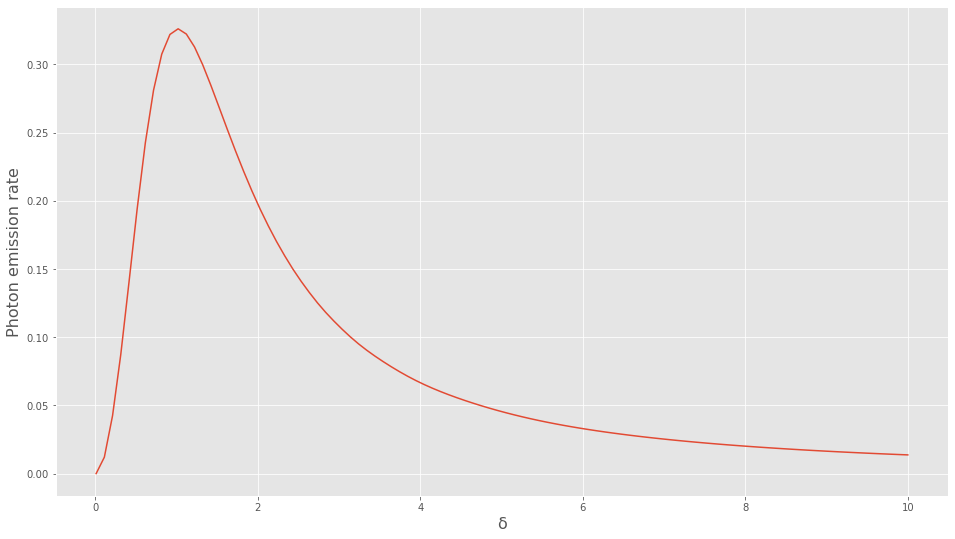

In [28]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(δs, rates)
ax.set_xlabel("δ", fontsize = 16)
ax.set_ylabel("Photon emission rate", fontsize = 16)

### Quantum Zeno effect
For very large Rabi rates, the system should stay in the dark state, since we are effectively constantly measuring the state of the system.

In [29]:
# Define values of energy splitting to use
Ωs = 10**np.linspace(-3, 1, 100)

# Generate list of arguments to pass to time evaluaation
args_list = [default_args.copy() | {'Omega_0': Ω, 'Omega_1': Ω} for Ω in Ωs]

# qutip.rhs_generate(Hqobj, c_qobj, args = default_args)
rates = np.array(joblib.Parallel(n_jobs = 10, backend='loky', verbose=True)(joblib.delayed(parallel_func)(args) for args in args_list))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.8s finished


Text(0, 0.5, 'Photon emission rate')

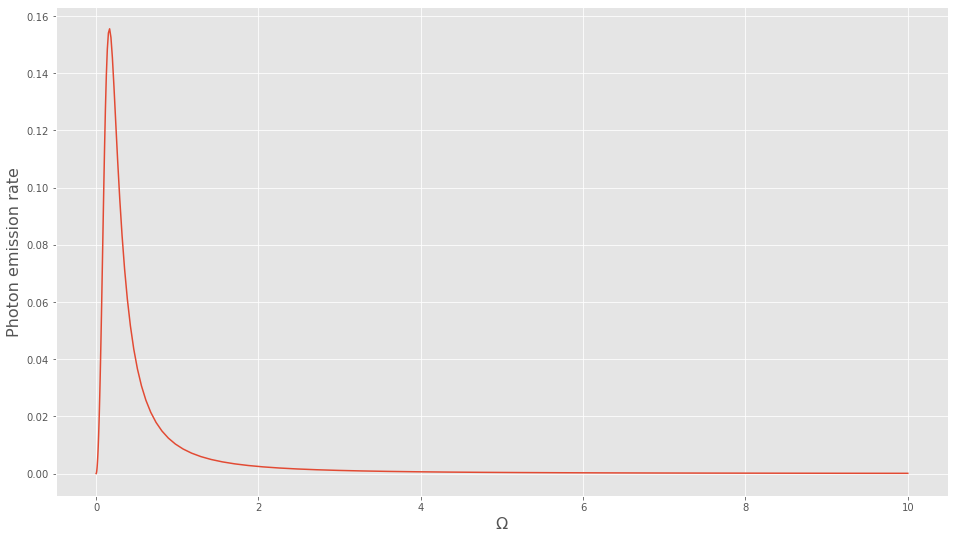

In [30]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(Ωs, rates)
ax.set_xlabel("Ω", fontsize = 16)
ax.set_ylabel("Photon emission rate", fontsize = 16)

### Effect of different Rabi rates
In real systems the coupling strengths of the ground states to the excited state are typically different. Perturbation theory says that this should have a large effect on the rate at which the dark state evolves into the bright state (effect $\propto \left(\frac{\Omega_0\Omega_1}{\Omega_0^2+\Omega_1^2}\right)^2$)

In [31]:
# Define values of energy splitting to use
Ωratios = 10**np.linspace(-3, 0, 100) # Defined as Omega_1/Omega_0

# Generate list of arguments to pass to time evaluaation
args_list = [default_args.copy() | {'Omega_1': Ω} for Ω in Ωratios]

qutip.rhs_clear()
rates = np.array(joblib.Parallel(n_jobs = 10, backend='loky', verbose=True)(joblib.delayed(parallel_func)(args) for args in args_list))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.2s finished


Text(0, 0.5, 'Photon emission rate')

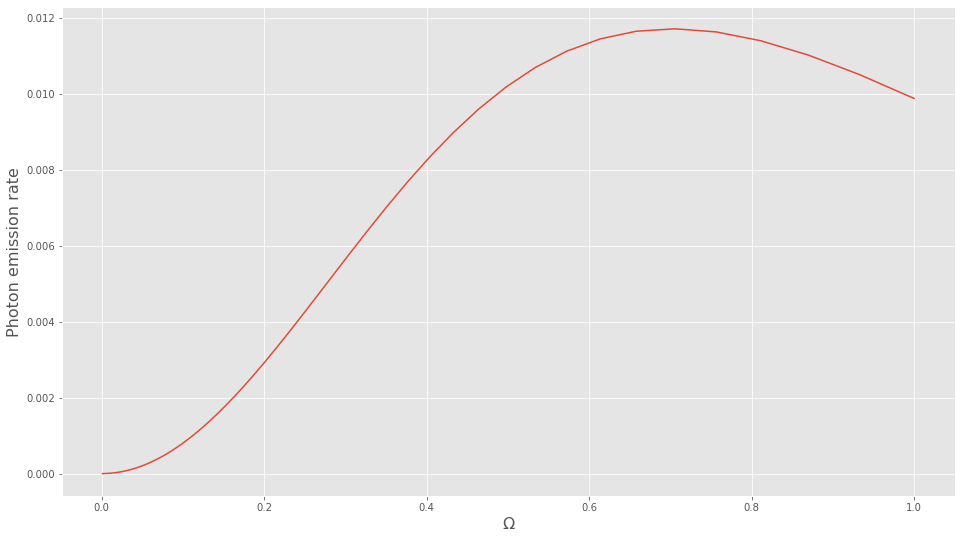

In [32]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(Ωratios, rates)
ax.set_xlabel("Ω", fontsize = 16)
ax.set_ylabel("Photon emission rate", fontsize = 16)